<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Ольга Дайховская (@aiho), Юрий Кашницкий (@yorko). 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 
## <center> Обучение без учителя

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/19oWnb5CxC5g-Zn45VWjuq_OP8YPCrn_g8Wq3aMaW2U4).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
%ls ../../data/samsung_HAR

samsung_test.txt          samsung_train.txt
samsung_test_labels.txt*  samsung_train_labels.txt*


In [3]:
X_train = np.loadtxt("../../data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../../data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../../data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [5]:

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
X.shape, y.shape 

((10299, 561), (10299,))

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:

pca = PCA(n_components=66, random_state=RANDOM_STATE)
X_centered = X_scaled - X_scaled.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [12]:
pca = PCA(0.9, svd_solver='full').fit(X_scaled)
pca.components_.shape

(65, 561)

In [92]:
cum_var = 0
for i, component in enumerate(pca.components_):
    cum_var += round(100 * pca.explained_variance_ratio_[i], 2)
    if (cum_var >= 90):
        print("{} components retains {:.2f}% of variance".format(i+1, cum_var))
        break

65 components retains 90.01% of variance


**Варианты:**
- 56 
- <font color="red">65</font>
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- <font color=red>51</font>
- 56
- 61

In [93]:
print(np.round(pca.explained_variance_ratio_[0] * 100))

51.0


Визуализируйте данные в проекции на первые две главные компоненты.

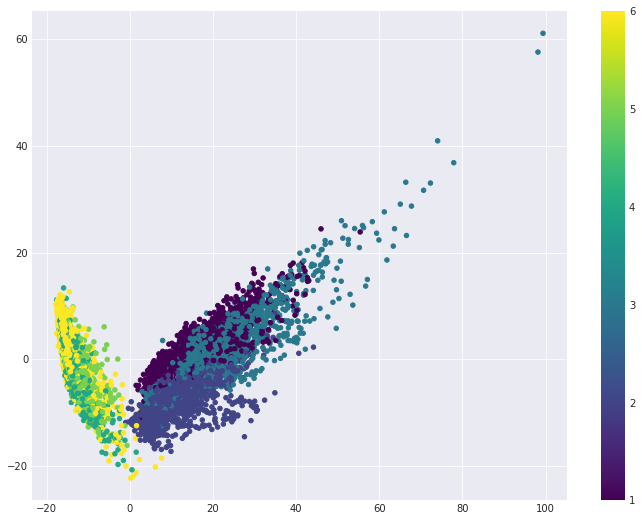

In [94]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='viridis');
plt.colorbar();

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- <font color=red>2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)</font>
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [96]:
pca2 = PCA(n_components=66, random_state=RANDOM_STATE)
X_pca2 = pca.fit_transform(X_scaled - X_scaled.mean(axis=0))
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca2);

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

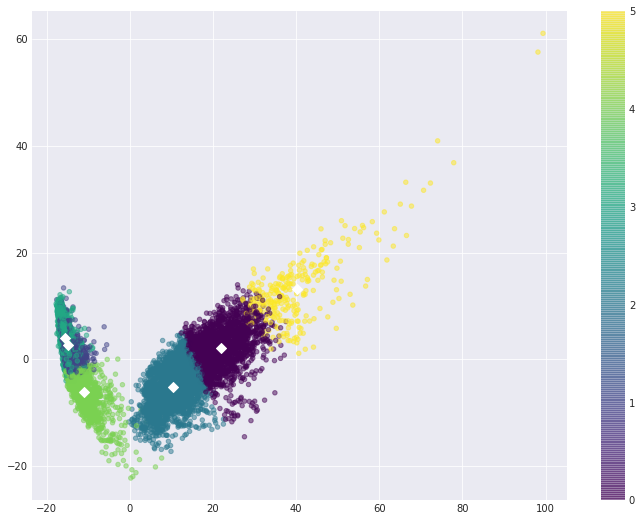

In [97]:
# Ваш код здесь
centroids = kmeans.cluster_centers_
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=cluster_labels, s=20,  cmap='viridis', alpha=0.5);
plt.colorbar();
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='D', s=50,
            color='w', zorder=10);

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [98]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,742,0,902,0,0,78,1722
подъем вверх по лестнице,295,0,1241,0,2,6,1544
спуск по лестнице,891,0,319,0,0,196,1406
сидение,0,1234,1,92,450,0,1777
стояние,0,1344,0,0,562,0,1906
лежание,0,53,5,1557,329,0,1944
все,1928,2631,2468,1649,1343,280,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- <font color=red>нет верного ответа</font>

In [99]:
tab.iloc[:,:-1].max(axis=1) / tab.iloc[:,6]

ходьба                      0.523810
подъем вверх по лестнице    0.803756
спуск по лестнице           0.633713
сидение                     0.694429
стояние                     0.705142
лежание                     0.800926
все                         0.255462
dtype: float64

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

A Jupyter Widget

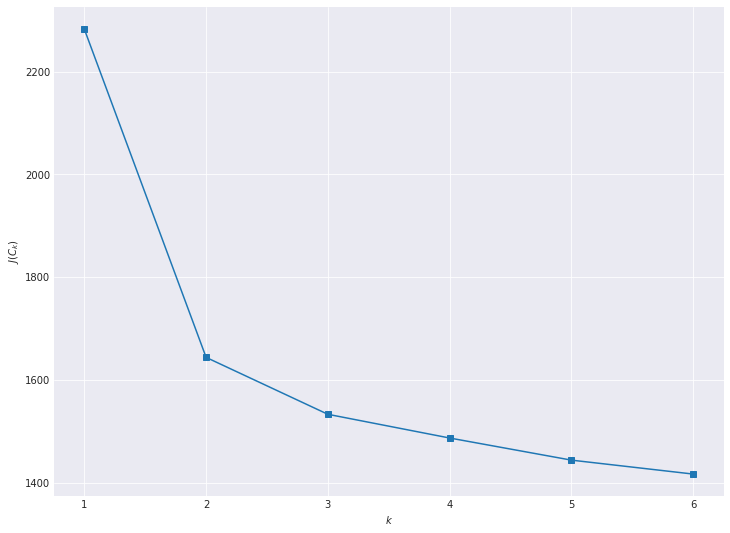

In [100]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE).fit(X_pca2)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- <font color="red">2</font>
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [103]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward')

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [104]:
(metrics.adjusted_rand_score(y, ag.fit_predict(X_pca2)), metrics.adjusted_rand_score(y, kmeans.predict(X_pca2)))

(0.51777045395667731, 0.41995047447766376)

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- <font color="red">Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering</font>
- <font color="red">Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры</font>
- <font color="red">В случае случайного разбиения на кластеры ARI будет близок к нулю</font>

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [113]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [114]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [115]:
%%time
best_svc = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3)
best_svc.fit(X_train_scaled, y_train);

CPU times: user 1min, sys: 360 ms, total: 1min
Wall time: 1min


In [116]:
best_svc.best_params_

{'C': 0.1}

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- <font color="red">0.1</font>
- 1
- 10

In [117]:
y_predicted = best_svc.predict(X_test_scaled)

In [139]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- <font color=red>по точности – стояние, по полноте – сидение</font> 

In [142]:
m = pd.DataFrame(data=np.zeros((6,2), np.float64), columns=['precision', 'recall'], index=tab.index[:-1], dtype=np.float64)
for i in range(6):
    m.iloc[i, 0] = round((tab.iloc[i,i]/tab.iloc[6,i]) * 100, 2)
    m.iloc[i, 1] = round((tab.iloc[i,i]/tab.iloc[i,6]) * 100, 2)
m

,precision,recall
ходьба,97.24,99.60
подъем вверх по лестнице,97.87,97.45
спуск по лестнице,100.00,98.33
сидение,96.38,86.76
стояние,87.78,97.18
лежание,100.00,97.95


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- <font color=red>4%</font> 
- 10%
- 20%


In [119]:
pca = PCA(n_components=66, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled - X_train_scaled.mean(axis=0))
X_test_pca = pca.transform(X_test_scaled)

In [120]:
%%time
best_svc = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3)
best_svc.fit(X_train_pca, y_train);
best_svc.best_params_

CPU times: user 13.7 s, sys: 76.2 ms, total: 13.8 s
Wall time: 13.6 s


In [121]:
y_predicted_pca = best_svc.predict(X_test_pca)

tab2 = pd.crosstab(y_test, y_predicted_pca, margins=True)
tab2.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab2.columns = tab2.index
tab2

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,477,13,6,0,0,0,496
подъем вверх по лестнице,49,408,14,0,0,0,471
спуск по лестнице,10,25,384,0,0,1,420
сидение,0,2,0,418,68,3,491
стояние,3,0,0,43,484,2,532
лежание,0,0,0,1,0,536,537
все,539,448,404,462,552,542,2947


In [124]:
n_right = 0
n_right_pca = 0
for i in range(0, 6):
    n_right += tab.iloc[i, i]
    n_right_pca += tab2.iloc[i, i]
print("N of right answers w/o PCA: {}, w/ PCA: {}".format(n_right, n_right_pca))
right_fraction = round((n_right/tab.iloc[6,6]) * 100, 0)
right_fraction_pca = round((n_right_pca/tab2.iloc[6,6]) * 100, 0)
print("Right answers fraction w/o PCA: {}%, w/ PCA: {}%".format(right_fraction, right_fraction_pca))
print("The difference = {}%".format(right_fraction - right_fraction_pca))

N of right answers w/o PCA: 2835, w/ PCA: 2707
Right answers fraction w/o PCA: 96.0%, w/ PCA: 92.0%
The difference = 4.0%


**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- <font color="red">PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность</font>
- <font color="red">PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком</font>